# Reflexivity in a diffusion of innovations model

This code tries to replicate the diffusion of innovations model present in

> *Diffusion dynamics in small-world networks with heterogeneous consumers* from Delre, Sebastiano A., Jager, Wander and Janssen, Marco A., Computational and Mathematical Organization Theory, **13**, 2, 2007.

with some modifications.

It also adds new features that try to introduce reflexivity in it.

In [2]:
# Necessary libraries

from __future__ import division

# Stdlin imports
import random

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import seaborn as sns

In [3]:
%matplotlib inline

In [382]:
#plt.style.use('seaborn-paper')
sns.set_style("whitegrid")

## 1. Auxiliary functions

### 1.1 For plots

In [4]:
def set_colors(graph):
    """
    Create a list of colors to apply to graph
    
    Adopters are blue and non-adopters are red
    """
    colors = []
    for n in graph.nodes():
        node = G.node[n]
        if node['adopter'] == 1:
            colors.append('b')
        else:
            colors.append('r')
    
    return colors

In [5]:
def draw_graph(graph, node_positions):
    """Function to draw the graph in which the evolution is occurring"""
    nx.draw_networkx_nodes(graph, node_positions, node_color=set_colors(graph), node_size=50)
    nx.draw_networkx_edges(graph, node_positions, width=0.3, alpha=0.5)

In [6]:
def animate(i, graph, node_positions, parameters, test=False):
    """Function to animate the algorithm evolution"""
    #print(i)
    if test:
        node = graph.node[i]
        node['adopter'] = 1
    else:
        evolution_step(graph, parameters)
    draw_graph(graph, node_positions)

### 1.2 For the algorithm

In [7]:
def get_neighbors(graph, node, level):
    """Get neighbors of a given node up to a certain level"""
    min_level = int(level)
    if min_level < level:
        max_level = min_level + 1
        percentaje = level - min_level
    else:
        max_level = level
        percentaje = 0
    
    # All neighbors up to max_level
    all_neighbors = nx.single_source_shortest_path_length(graph, node, cutoff=max_level)
    
    if percentaje > 0:
        neighbors_min_level = [k for (k, v) in all_neighbors.items() if (1 <= v <= min_level)]
        neighbors_max_level = [k for (k, v) in all_neighbors.items() if v == max_level]
        n = np.round(len(neighbors_max_level) * percentaje)
        additional_neighbors = random.sample(neighbors_max_level, int(n))
        neighbors = neighbors_min_level + additional_neighbors
    else:
        neighbors = [k for (k, v) in all_neighbors.items() if (1 <= v <= max_level)]
    
    return neighbors

In [8]:
def is_adopter(graph, node):
    """Return True if a node is an adopter"""
    return graph.node[node]['adopter'] == 1

In [9]:
def get_adopters(graph):
    """Get the nodes that are adopters in the graph"""
    return [x for x in graph.nodes() if is_adopter(graph, x)]

In [10]:
def speed_of_diffusion(adopters):
    """
    Compute the velocity of diffusion $rho$
    
    This is done according to equation 6 in the article
    """
    T = len(adopters)
    cumulative_adopters = np.cumsum(adopters)
    return (1/T) * ( sum(cumulative_adopters) / sum(adopters) )

In [11]:
def homophily_index(graph):
    """
    Return the number of cross-gender edges over the total number of edges
    
    Cross-gender edges mean edges between adopters and non-adopters
    """
    cross_gender_edges = []
    for e in graph.edges():
        i = e[0]
        j = e[1]
        if is_adopter(graph, i) and not is_adopter(graph, j) or is_adopter(graph, j) and not is_adopter(graph, i):
            cross_gender_edges.append(e)
    
    #print( len(cross_gender_edges), len(graph.edges()) )
    return len(cross_gender_edges) / len(graph.edges())

In [12]:
def clustering_index(graph):
    """
    Return an index that quantifies how big the size of adopter
    clusters is in the entire population of consumers
    
    This index computes the cluster-size-weighted average of adopter
    clusters divided by the total number of consumers
    
    So it goes from 0 to 1 and it's always increasing.
    """
    N = len(graph.nodes())
    adopters = get_adopters(graph)
    
    clusters = nx.subgraph(graph, adopters)
    cluster_sizes = [len(c) for c in nx.connected_components(clusters) if len(c) > 1]
    if cluster_sizes:
        # The weight of each cluster depends on its size
        weights = np.array(cluster_sizes) / N
        # Compute the weighted average
        weigthed_average = np.average(cluster_sizes, weights=weights)
        # Since the index needs to go between 0 and 1, we need to divide between N
        # again
        index = weigthed_average / N
        return index
    else:
        return 0

In [230]:
def logistic(x, k, x0):
    """
    Logistic function
    
    See https://en.wikipedia.org/wiki/Logistic_function for
    its parameters
    """
    if x == 0:
        return 0
    else:
        return 1 / ( 1 + np.exp(-k * (x - x0)) )

In [14]:
def step(x, k, x0):
    """
    Step function
    
    Taken from http://stackoverflow.com/a/28892278/438386
    
    k is not needed but it's added here to have the same interface as
    the logistic function above
    """
    return 1. * (x > x0)

In [15]:
def set_seed(graph, parameters, reset=False):
    """Set initial seed of adopters"""
    # Set all adopters to 0
    if reset:
        for node_index in graph.nodes():
            node = graph.node[node_index]
            node['adopter'] = 0
    
    seed = np.round(len(graph.nodes()) * parameters['initial_seed'])
    initial_adopters = random.sample(graph.nodes(), int(seed))
        
    for node_index in initial_adopters:
        node = graph.node[node_index]
        node['adopter'] = 1

## 2. Algorithm

In [22]:
def generate_initial_conditions(parameters):
    """
    Initial conditions for the simulation
    
    Create the graph on which the diffusion occurs and set additional
    attributes for its node
    
     `parameters` is a dictionary that contains the parameters that control
     the evolution.
    """
    # Graph creation
    G = nx.generators.watts_strogatz_graph(parameters['number_of_consumers'],
                                           parameters['number_of_neighbors'],
                                           parameters['randomness'])
    
    # Graph properties
    for node_index in G.nodes():
        node = G.node[node_index]
        node['adopter'] = 0                              # 1 is adopter, 0 non-adopter
        node['preference'] = np.random.random()          # pi
        #node['minimal_utility'] = np.random.random()
        
        # Neighbors never change if the level is an int
        if int(parameters['level']) - parameters['level'] == 0:
            node['neighbors'] = get_neighbors(G, node_index, parameters['level'])
        else:
            node['neighbors'] = []
    
    # Create a seed of initial adopters if there's no marketing
    # if not parameters['marketing_effort']:
    #    set_seed(G, parameters)
    
    return G

In [18]:
def evolution_step(graph, parameters, test=False):
    """
    Function that computes the evolution step of the diffusion process
    that occurs in a small-world graph
    
    `parameters` is a dictionary that contains the parameters that
    control the evolution.
    """
    
    #minimal_utility = parameters['minimal_utility']
    
    # Adopters before performing the current step
    previous_adopters = get_adopters(graph)
    
    # To save the adopters at this time step
    adopters_at_step = []
    
    # Compute quantities that depend on the global state of the system.
    # Thus they are the same for all agents during this time step
    if parameters['reflexivity']:
        # Compute utility due to indirect social influence
        indirect_utility = clustering_index(graph)

        # Decide which activation function to use.
        if not test:
            activation = logistic
        else:
            activation = step
        
        # Compute reflexivity index
        reflexivity_index = activation(indirect_utility,
                                       parameters['activation_sharpness'],
                                       parameters['critical_mass'])
        #print(reflexivity_index)
    
    
    # Determine which agents adopt
    for node_index in graph.nodes():
        node = graph.node[node_index]

        # -- Adoption due to marketing
        if parameters['marketing_effort']:
            p = np.random.random()
            if not node['adopter'] and (p < parameters['marketing_effort']):
                adopters_at_step.append(node_index)
                continue

        # -- Compute utility due to direct social influence
        # Adopters
        if node['neighbors']:
            neighbors = node['neighbors']
        else:
            neighbors = get_neighbors(graph, node_index, level=parameters['level'])
        adopters_among_neighbors = [x for x in neighbors if is_adopter(graph, x)]

        # Only if a consumer has adopters among his neighbors, he computes
        # his direct utility
        if len(adopters_among_neighbors) > 0:

            # Ai value
            adopters_percentaje = len(adopters_among_neighbors) / len(neighbors)

            # Computing xi
            if adopters_percentaje > parameters['adopters_threshold']:
                local_influence = 1
            else:
                local_influence = 0
            
            # Set individual preference (yi)
            if parameters['quality'] >= node['preference']:
                individual_preference = 1
            else:
                individual_preference = 0

            # Computing utility Ui
            direct_utility = parameters['social_influence'] * local_influence + \
                             (1 - parameters['social_influence']) * individual_preference
        else:
            direct_utility = 0
        
        # -- Compute utility if reflexivity is on or off
        if parameters['reflexivity']:
            # Compute utility if agent has become aware of a global pattern
            # or not
            alpha = np.random.random()
            if alpha < reflexivity_index:
                utility = direct_utility + indirect_utility - direct_utility * indirect_utility
            else:
                utility = direct_utility
        else:
            utility = direct_utility
        
        # Decide to adopt if agent's utility is higher than a minimal
        # utility
        minimal_utility = np.random.random()
        if minimal_utility <= utility:
            adopters_at_step.append(node_index)
        
        # print(utility)
        #if utility > node['minimal_utility']: #minimal_utility:
        #    if np.random.random() > node['minimal_utility']:
        #        node['adopter'] = 1
    
    # Update the graph with customers who adopted in this time step
    for node_index in adopters_at_step:
        node = graph.node[node_index]
        node['adopter'] = 1
    
    # Return number of adopters at time t
    current_adopters = get_adopters(graph)
    return len(current_adopters) - len(previous_adopters)

In [18]:
def evolution(graph, parameters, max_time='complete_adoption', compute_index=False, test=False):
    """Compute the evolution of the algorithm up to max_time"""
    # Save the adopters at each time during the evolution
    adopters = []
    
    # Compute the aggregation index during the evolution
    if compute_index:
        indexes = []
    
    # Perform the evolution
    if max_time == 'complete_adoption':
        while not all( [is_adopter(graph, x) for x in graph.nodes()] ):
            adopters_at_t = evolution_step(graph, parameters, test)
            adopters.append(adopters_at_t)
            if compute_index:
                indexes.append(clustering_index(graph))
    else:
        for t in range(max_time):
            adopters_at_t = evolution_step(graph, parameters, test)
            adopters.append(adopters_at_t)
    
    if compute_index:
        return indexes
    else:
        return adopters

In [377]:
def compute_run(number_of_times, parameters, max_time='complete_adoption'):
    """
    Compute a run of the algorithm
    
    A run consists in repeating the evolution of the algorithm under
    the same conditions a certain number_of_times
    """
    # Print the parameters of the run
    print(parameters)

    # Perform the run
    no_rx_data = []
    rx_data = []
    for i in range(number_of_times):
        G = generate_initial_conditions(parameters)

        # No reflexivity data
        parameters['reflexivity'] = False
        set_seed(G, parameters)
        adopters_no_rx = evolution(G, parameters, max_time=max_time)
        no_rx_data.append(adopters_no_rx)

        # Reflexivity data
        parameters['reflexivity'] = True
        set_seed(G, parameters, reset=True)
        adopters_rx = evolution(G, parameters, max_time=max_time)
        rx_data.append(adopters_rx)
    
    data = [no_rx_data, rx_data]
    
    # Make the evolution lists of the same length so they can be
    # passed to Seaborn
    if max_time == 'complete_adoption':
        uniform_data = []
        for li in data:
            max_length = max([len(x) for x in li])
            new_li = [x + [0] * (max_length - len(x)) for x in li]
            uniform_data.append(new_li)
        return uniform_data
    else:
        return data

## 3. Running the model

### 3.1 Parameters

These are main parameters that control the evolution of the algorithm, and their corresponding variable in the article:

* Network randomness: $r$
* Average number of neighbors: $k$
* Initial proportion (or seed) of adopters: $\delta$
* Coefficient of social influence: $\beta$
* Threshold of adopters among neighbors: $h$
* Quality: $q$
* Total number of consumers: $N$
* Activation sharpness: $\phi$
* Critical mass of adopters: $M_{c}$

----

* Marketing effort: $e_{1}$
* Level: $L$

In [395]:
parameters = dict(
    randomness = 0.01,
    number_of_neighbors = 15,
    initial_seed = 0.001,
    adopters_threshold = 0.7,
    social_influence = 0.1,
    quality = 0.5,
    number_of_consumers = 1000,
    activation_sharpness = 20,
    critical_mass = 0.85,
    ## -- Not considered for now 
    marketing_effort = 0,
    level = 1
    #minimal_utility = 0.5,
)

### 3.2 Simulation

#### 3.2.1 Full run

In [378]:
data = compute_run(30, parameters, max_time=100)

{'number_of_consumers': 1000, 'social_influence': 0.7, 'randomness': 0.01, 'activation_sharpness': 20, 'level': 1, 'quality': 0.5, 'initial_seed': 0.001, 'critical_mass': 0.85, 'number_of_neighbors': 30, 'adopters_threshold': 0.3, 'marketing_effort': 0}


#### 3.2.2 Single run

In [189]:
G = generate_initial_conditions(parameters)

In [94]:
parameters['reflexivity'] = False
set_seed(G, parameters, reset=True)
adopters_no_rx = evolution(G, parameters, max_time=20)

In [96]:
parameters['reflexivity'] = True
set_seed(G, parameters, reset=True)
adopters_rx = evolution(G, parameters, max_time=20)

## 4. Plots

### 4.1 2d plots

#### 4.1.1 Full run

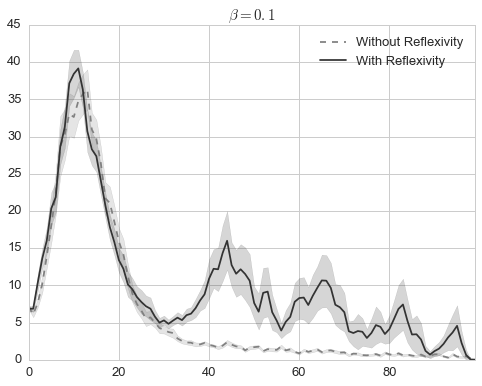

In [84]:
plt.figure(figsize=(8, 6))
sns.tsplot(data=data[0], color='0.5', condition='Without Reflexivity', linestyle='--')
sns.tsplot(data=data[1], color='0.2', condition='With Reflexivity')
plt.title(r'$\beta = %s$' % parameters['social_influence'], fontsize=15)
plt.legend(loc='upper right', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=13)

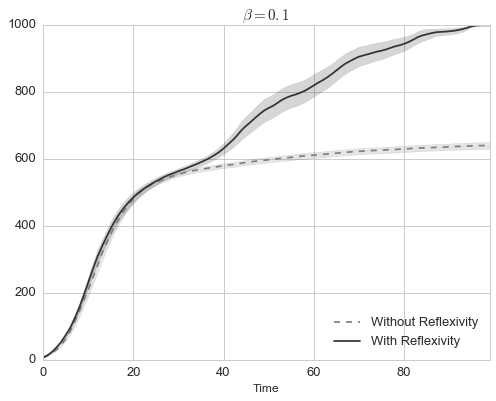

In [83]:
# Plot the cumulative sum of adopters and non-adopters (the usual diffusion curve)
plt.figure(figsize=(8, 6))
sns.tsplot(data=map(np.cumsum, data[0]), color='0.5', condition='Without Reflexivity', linestyle='--')
sns.tsplot(data=map(np.cumsum, data[1]), color='0.2', condition='With Reflexivity')
plt.title(r'$\beta = %s$' % parameters['social_influence'], fontsize=15)
plt.xlabel("Time", fontsize=12)
plt.legend(loc='lower right', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=13)

#### 4.1.2 Single run

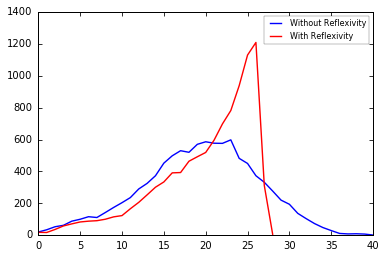

In [460]:
plt.plot(adopters_no_rx, 'b', label='Without Reflexivity')
plt.plot(adopters_rx, 'r', label='With Reflexivity')
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=10)

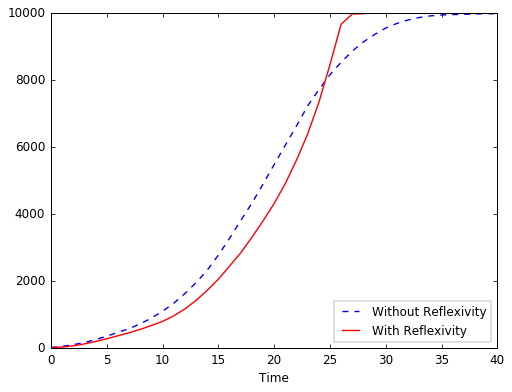

In [472]:
# Plot the cumulative sum of adopters and non-adopters (the usual diffusion curve)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(adopters_no_rx), '--', color='b', label='Without Reflexivity')
plt.plot(np.cumsum(adopters_rx), color='r', label='With Reflexivity')
plt.xlabel("Time", fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

### 4.2 Logistic function form

This explores how the logistic function changes under different values of $k$ and $x_{0}$

In [55]:
from sympy import plot, symbols, exp

In [56]:
x = symbols('x')

In [474]:
def symbolic_logistic(x, k, x0):
    return 1 / ( 1 + exp(-k * (x - x0)) )

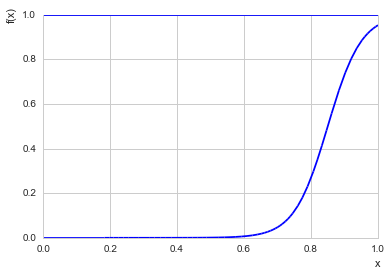

In [297]:
plot(symbolic_logistic(x, 20, 0.85), 1, (x, 0, 1))

In [476]:
symbolic_logistic(1, 15, 0.8)

0.952574126822433

### 4.3 Animations

In [ ]:
%matplolib qt

In [ ]:
G = generate_initial_conditions(1000, parameters)

In [ ]:
# Plot an animation of the evolution
fig = plt.figure()
positions = nx.spring_layout(G)
animation.FuncAnimation(fig, lambda i: animate(i, G, positions, parameters, test=False),
                        frames=500, interval=3, repeat=False)